In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Fri Jan 12 00:34:34 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    17W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-7/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 80152
-rw-rw-r-- 1 scpark scpark   772292  1월 12 00:09 events.out.tfevents.1704985394.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37973949  1월 12 00:03 save_0
-rw-rw-r-- 1 scpark scpark   631844  1월 12 00:03 events.out.tfevents.1704985062.GPUSVR01
-rw-rw-r-- 1 scpark scpark   327908  1월 11 23:57 events.out.tfevents.1704984883.GPUSVR01
-rw-rw-r-- 1 scpark scpark   400772  1월 11 23:54 events.out.tfevents.1704984677.GPUSVR01
-rw-rw-r-- 1 scpark scpark  1111076  1월 11 22:02 events.out.tfevents.1704977558.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 11 22:00 save_10000
-rw-rw-r-- 1 scpark scpark   968996  1월 11 21:52 events.out.tfevents.1704977059.GPUSVR01
-rw-rw-r-- 1 scpark scpark  1884284  1월 11 21:44 events.out.tfevents.1704976090.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


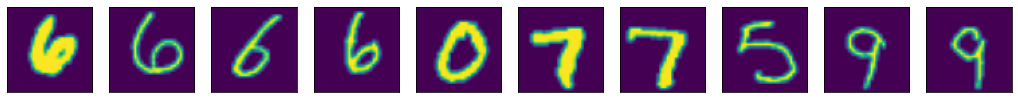

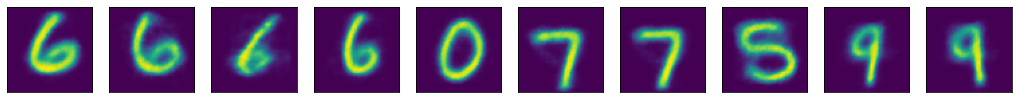

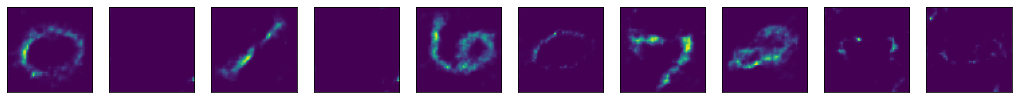

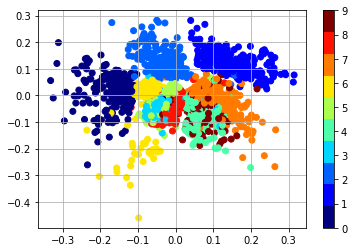

21001
lse_loss -4.602378845214844
recon_loss 0.10842489451169968
21002
lse_loss -4.600308418273926
recon_loss 0.10012103617191315
21003
lse_loss -4.60135555267334
recon_loss 0.10994987189769745
21004
lse_loss -4.602349281311035
recon_loss 0.1024722158908844
21005
lse_loss -4.598031997680664
recon_loss 0.11511816829442978
21006
lse_loss -4.601443767547607
recon_loss 0.10692273080348969
21007
lse_loss -4.596494197845459
recon_loss 0.10621245950460434
21008
lse_loss -4.606313228607178
recon_loss 0.10401444882154465
21009
lse_loss -4.5993852615356445
recon_loss 0.11243518441915512
21010
lse_loss -4.5981245040893555
recon_loss 0.10013534873723984
21011
lse_loss -4.599207878112793
recon_loss 0.09887051582336426
21012
lse_loss -4.601241588592529
recon_loss 0.09604988992214203
21013
lse_loss -4.599700927734375
recon_loss 0.09788920730352402
21014
lse_loss -4.596216201782227
recon_loss 0.10698652267456055
21015
lse_loss -4.599319934844971
recon_loss 0.10798197984695435
21016
lse_loss -4.5981235

21129
lse_loss -4.604245662689209
recon_loss 0.1040378138422966
21130
lse_loss -4.598719120025635
recon_loss 0.10830357670783997
21131
lse_loss -4.594563961029053
recon_loss 0.10597371309995651
21132
lse_loss -4.60343599319458
recon_loss 0.11545901745557785
21133
lse_loss -4.600154399871826
recon_loss 0.11007668077945709
21134
lse_loss -4.5984368324279785
recon_loss 0.11099402606487274
21135
lse_loss -4.604341506958008
recon_loss 0.11901208013296127
21136
lse_loss -4.597631931304932
recon_loss 0.11494851112365723
21137
lse_loss -4.602207660675049
recon_loss 0.10291922092437744
21138
lse_loss -4.599132537841797
recon_loss 0.10664133727550507
21139
lse_loss -4.601478099822998
recon_loss 0.10578969120979309
21140
lse_loss -4.599307537078857
recon_loss 0.11271791905164719
21141
lse_loss -4.599650859832764
recon_loss 0.10819792747497559
21142
lse_loss -4.597123146057129
recon_loss 0.11620621383190155
21143
lse_loss -4.599544048309326
recon_loss 0.11594297736883163
21144
lse_loss -4.59541368

21257
lse_loss -4.6022820472717285
recon_loss 0.11089026182889938
21258
lse_loss -4.599647521972656
recon_loss 0.10233677923679352
21259
lse_loss -4.601208686828613
recon_loss 0.10599639266729355
21260
lse_loss -4.596357822418213
recon_loss 0.10716739296913147
21261
lse_loss -4.59970235824585
recon_loss 0.11003183573484421
21262
lse_loss -4.600599765777588
recon_loss 0.09872196614742279
21263
lse_loss -4.597134590148926
recon_loss 0.10396823287010193
21264
lse_loss -4.600923538208008
recon_loss 0.11354351043701172
21265
lse_loss -4.598616123199463
recon_loss 0.11265920847654343
21266
lse_loss -4.59983491897583
recon_loss 0.11931127309799194
21267
lse_loss -4.602999687194824
recon_loss 0.10983683913946152
21268
lse_loss -4.598550796508789
recon_loss 0.10311402380466461
21269
lse_loss -4.598844051361084
recon_loss 0.1184367761015892
21270
lse_loss -4.5964460372924805
recon_loss 0.09962503612041473
21271
lse_loss -4.602152347564697
recon_loss 0.10895057767629623
21272
lse_loss -4.60002326

21387
lse_loss -4.596142768859863
recon_loss 0.1016865000128746
21388
lse_loss -4.599623203277588
recon_loss 0.11618152260780334
21389
lse_loss -4.600076675415039
recon_loss 0.10719456523656845
21390
lse_loss -4.605663299560547
recon_loss 0.1092834323644638
21391
lse_loss -4.6007537841796875
recon_loss 0.11300665140151978
21392
lse_loss -4.59669828414917
recon_loss 0.1186547502875328
21393
lse_loss -4.600278854370117
recon_loss 0.10915032029151917
21394
lse_loss -4.602190017700195
recon_loss 0.11056949943304062
21395
lse_loss -4.599430561065674
recon_loss 0.11245344579219818
21396
lse_loss -4.598926544189453
recon_loss 0.10562445968389511
21397
lse_loss -4.599375247955322
recon_loss 0.10302388668060303
21398
lse_loss -4.599555492401123
recon_loss 0.10719972103834152
21399
lse_loss -4.5937724113464355
recon_loss 0.10640986263751984
21400
lse_loss -4.597973823547363
recon_loss 0.10188576579093933
21401
lse_loss -4.594527721405029
recon_loss 0.11234492063522339
21402
lse_loss -4.601659297

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=2e-0)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        